In this analysis, we will use non-parametrical Mann-Whitney criteria and bootstrap method of statististical testing to evaluate the relationship between employees' education and their year-end grade.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm, mannwhitneyu, kruskal
from scipy import stats
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

plt.style.use('ggplot')

In [4]:
%matplotlib inline

First, certain corrections are needed to be able to work with the dataset.

In [5]:
result = pd.read_csv("bootstrap.csv", sep = ";", encoding="windows-1251")

In [6]:
result['h'] = result['h'].str.replace(',', '.')

In [7]:
result = result[result.h != 'no data']

In [8]:
result = result.astype({'h': 'float'})

In [9]:
result.dtypes

F     object
h    float64
dtype: object

F variable refers to 5 different grades for an employee's year-end assessment. h variable is the number of training hours in a year per employee. Only certain types of education are included in this analysis - those that can be chosen by an employee to help him or her move along the career path or become an expert in a certain professional field.  

In [10]:
# number of values in each group
result.F.value_counts()

3          6786
no data    4751
4          1878
2           677
5           151
1            46
Name: F, dtype: int64

In [11]:
# number of values in each group
result['h'].describe()

count    14289.000000
mean         6.604597
std         19.901644
min          0.000000
25%          0.000000
50%          0.000000
75%          3.500000
max        698.500000
Name: h, dtype: float64

## Mean and median values

In [17]:
result.groupby('F', as_index = False).mean()

,F,h
0,1,4.489130
1,2,7.361152
2,3,8.546401
3,4,11.691001
4,5,12.304636
5,no data,1.551989


In [18]:
result.groupby('F', as_index = False).median()

,F,h
0,1,1.25
1,2,1.00
2,3,1.00
3,4,2.00
4,5,1.50
5,no data,0.00


In [19]:
result.groupby('F', as_index = False).count()

,F,h
0,1,46
1,2,677
2,3,6786
3,4,1878
4,5,151
5,no data,4751


Two of the most common year-end assessments are '3' and '4'. Let's calculate statistics for training hours associated with them.

In [13]:
result[result.F == '3']["h"].describe(percentiles=[0.75, 0.95, 0.99])

count    6786.000000
mean        8.546401
std        23.040681
min         0.000000
50%         1.000000
75%         6.000000
95%        43.875000
99%        80.575000
max       698.500000
Name: h, dtype: float64

In [14]:
result[result.F == '4']["h"].describe(percentiles=[0.75, 0.95, 0.99])

count    1878.000000
mean       11.691001
std        25.654038
min         0.000000
50%         2.000000
75%        14.000000
95%        51.000000
99%       110.110000
max       436.000000
Name: h, dtype: float64

Their is a tendency evident from comparing these numbers - the number of training hours is bigger for those with a higher year-end grade. 

## 2 samples of 1000 each, Mann-Whitney criteria, Shapiro-Wilk test of normality

In [21]:
sample_1 = result[result.F == '4']["h"].sample(1000)
stats.shapiro(sample_1)

ShapiroResult(statistic=0.4193333387374878, pvalue=0.0)

In [22]:
sample_0 = result[result.F == '3']["h"].sample(1000)
stats.shapiro(sample_0)

ShapiroResult(statistic=0.2663702964782715, pvalue=0.0)

Both samples do not pass tests for normality, as they are far from normal

In [23]:
stat, p = mannwhitneyu(sample_0, sample_1)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=462695.000, p=0.003


p-value is lower than 0.05, therefore we have enough evidence to reject the null hypothesis of no differences between the groups at the determined level of significance.

In [24]:
sample_0.describe()

count    1000.000000
mean        8.411300
std        27.295239
min         0.000000
25%         0.000000
50%         1.000000
75%         6.000000
max       681.000000
Name: h, dtype: float64

In [25]:
sample_1.describe()

count    1000.00000
mean       12.01765
std        29.03644
min         0.00000
25%         0.00000
50%         2.00000
75%        14.00000
max       436.00000
Name: h, dtype: float64

## Comparing mean values using bootstrap

In [26]:
x = np.array(sample_0)
y = np.array(sample_1)

df_xy = pd.DataFrame({"x": x, "y": y})
df_xy = df_xy.astype({"x": float, "y": float})
df_xy.dtypes

x    float64
y    float64
dtype: object

In [27]:
len(x)

1000

In [28]:
def get_bootstrap(
    data_column_1, # values of the first sample
    data_column_2, # values of the second sample
    boot_it = 1000, # number of bootstrap sub-samples
    statistic = np.mean, # our target statistics
    bootstrap_conf_level = 0.95 # significance level
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # sub-sampling
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # replace parameter
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - applying statistical criteria
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # visualizing
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/2000 [00:00<?, ?it/s]

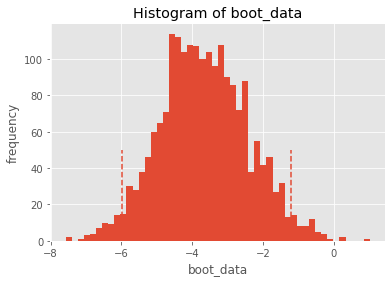

In [29]:
booted_data = get_bootstrap(df_xy.x, df_xy.y, boot_it = 2000)

In [30]:
booted_data["p_value"]

0.003065415930834807

In [31]:
booted_data["ci"]

,0
0.025,-5.989600
0.975,-1.199071


0 не входит в получившийся доверительный интервал, p-value меньше 0.05, следовательно, у нас достаточно оснований отвергнуть нулевую гипотезу об отсутствии различий среднего значений метрики при 95% уровне значимости.

0 is not included in the resulting confidence interval, p-value is less that 0.05, therefore we have enough evidence to reject the null hypothesis of no differences between the groups at the 95% level of significance.

The differences in training hours between those who received a lower and a higher year-end grade are not random. There is a relationship between these 2 variables. It is possible to assume that those that participate in voluntary training work at a higher efficiency rate (and more efficient employees pay more attention to their training), are more motivated, can invest more time and energy into their self-development, are more interested in the activities within the company, all of which is expressed in a higher year-end assessment.